<a href="https://colab.research.google.com/github/whitechocobread/Ai-project/blob/main/Colaboratory%EC%97%90_%EC%98%A4%EC%8B%A0_%EA%B2%83%EC%9D%84_%ED%99%98%EC%98%81%ED%95%A9%EB%8B%88%EB%8B%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install transformers

In [42]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 925.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=400ffc527821adcc163a91e36ae54bd72f847d0a444cc3d92adad52eab0843a2
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [43]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import re
import os
import urllib.request
from tqdm import tqdm
from transformers import BertTokenizer, TFBertForSequenceClassification

In [44]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import pandas as pd

file_path = '/content/drive/MyDrive/삼성전자.xlsx'
data = pd.read_excel(file_path)

# 데이터 확인
print(data.head())



   labels                            Description 
0      -2         삼성전자 폴더블폰 시장 점유율이 86%에서 72%로 하락
1       1  글로벌 폴더블폰 시장이 전년 대비 16%, 전분기 대비 215% 증가
2      -1         중국 업체들의 공격적인 제품 출시로 삼성전자 점유율 하락
3       2      삼성 갤럭시Z 플립5와 폴드5, 시장에서 가장 잘 팔리는 모델
4       1  4분기 삼성전자 폴더블폰 점유율, 작년 83%에서 42%로 하락 예상


In [46]:
data

,labels,Description
0,-2,삼성전자 폴더블폰 시장 점유율이 86%에서 72%로 하락
1,1,"글로벌 폴더블폰 시장이 전년 대비 16%, 전분기 대비 215% 증가"
2,-1,중국 업체들의 공격적인 제품 출시로 삼성전자 점유율 하락
3,2,"삼성 갤럭시Z 플립5와 폴드5, 시장에서 가장 잘 팔리는 모델"
4,1,"4분기 삼성전자 폴더블폰 점유율, 작년 83%에서 42%로 하락 예상"
...,...,...
105,1,TSMC는 아이폰15·PC용 반도체 주문이 몰리며 실적 증가
106,-1,삼성전자는 중저가 5세대 AP 시스템온칩과 OLED DDI 주문 증가
107,0,세계 파운드리 시장 점유율 순위에서 삼성전자는 2위
108,-1,TSMC의 최첨단 3나노 제품이 매출의 6%를 차지


In [47]:
data['labels'] = data['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
data[:5]

,labels,Description
0,-2,삼성전자 폴더블폰 시장 점유율이 86%에서 72%로 하락
1,1,"글로벌 폴더블폰 시장이 전년 대비 16%, 전분기 대비 215% 증가"
2,-1,중국 업체들의 공격적인 제품 출시로 삼성전자 점유율 하락
3,2,"삼성 갤럭시Z 플립5와 폴드5, 시장에서 가장 잘 팔리는 모델"
4,1,"4분기 삼성전자 폴더블폰 점유율, 작년 83%에서 42%로 하락 예상"


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        110 non-null    int64 
 1   Description   110 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [49]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [50]:
print('Description 열의 유니크한 값 :', data['Description '].nunique())

Description 열의 유니크한 값 : 110


In [51]:
duplicate = data[data.duplicated()]
duplicate

,labels,Description


In [52]:
# 중복 제거
data.drop_duplicates(subset=['Description '], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 110


<Axes: >

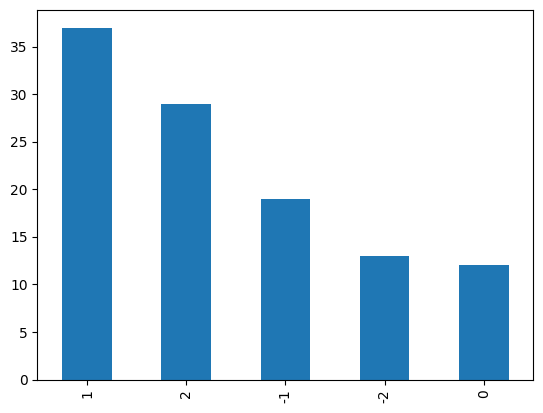

In [53]:
data['labels'].value_counts().plot(kind='bar')

In [54]:
print('레이블의 분포')
print(data.groupby('labels').size().reset_index(name='count'))

레이블의 분포
   labels  count
0      -2     13
1      -1     19
2       0     12
3       1     37
4       2     29


In [55]:
print(f'중립의 비율 = {round(data["labels"].value_counts()[0]/len(data) * 100,3)}%')
print(f'긍정의 비율 = {round(data["labels"].value_counts()[1]/len(data) * 100,3)}%')
print(f'부정의 비율 = {round(data["labels"].value_counts()[2]/len(data) * 100,3)}%')

중립의 비율 = 10.909%
긍정의 비율 = 33.636%
부정의 비율 = 26.364%


In [56]:
data

,labels,Description
0,-2,삼성전자 폴더블폰 시장 점유율이 86%에서 72%로 하락
1,1,"글로벌 폴더블폰 시장이 전년 대비 16%, 전분기 대비 215% 증가"
2,-1,중국 업체들의 공격적인 제품 출시로 삼성전자 점유율 하락
3,2,"삼성 갤럭시Z 플립5와 폴드5, 시장에서 가장 잘 팔리는 모델"
4,1,"4분기 삼성전자 폴더블폰 점유율, 작년 83%에서 42%로 하락 예상"
...,...,...
105,1,TSMC는 아이폰15·PC용 반도체 주문이 몰리며 실적 증가
106,-1,삼성전자는 중저가 5세대 AP 시스템온칩과 OLED DDI 주문 증가
107,0,세계 파운드리 시장 점유율 순위에서 삼성전자는 2위
108,-1,TSMC의 최첨단 3나노 제품이 매출의 6%를 차지


In [57]:
X_data = data['Description ']
y_data = data['labels']
print('본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

본문의 개수: 110
레이블의 개수: 110


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)
print('훈련 샘플의 개수 :', len(X_train))
print('테스트 샘플의 개수 :', len(X_test))


훈련 샘플의 개수 : 88
테스트 샘플의 개수 : 22


In [59]:
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
중립 = 11.364%
긍정 = 34.091%
부정 = 26.136%


In [60]:
print('--------테스트 데이터의 비율-----------')
print(f'중립 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'긍정 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')
print(f'부정 = {round(y_test.value_counts()[2]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
중립 = 9.091%
긍정 = 31.818%
부정 = 27.273%


In [61]:
max_seq_len = 128
tokenizer = BertTokenizer.from_pretrained('klue/bert-base')

In [62]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):

    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []

    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        # input_id는 워드 임베딩을 위한 문장의 정수 인코딩
        input_id = tokenizer.encode(example, max_length=max_seq_len, pad_to_max_length=True)

        # attention_mask는 실제 단어가 위치하면 1, 패딩의 위치에는 0인 시퀀스.
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count

        # token_type_id은 세그먼트 인코딩
        token_type_id = [0] * max_seq_len

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

In [63]:
train_X, train_y = convert_examples_to_features(X_train, y_train, max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/88 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 88/88 [00:00<00:00, 634.05it/s]


In [64]:
test_X, test_y = convert_examples_to_features(X_test, y_test, max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 22/22 [00:00<00:00, 613.85it/s]


In [65]:
input_id = train_X[0][0]
attention_mask = train_X[1][0]
token_type_id = train_X[2][0]
label = train_y[0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))
print('레이블 :',label)

단어에 대한 정수 인코딩 : [    2  7275    55 21455    42  2105  2079  8256 26219 15388   100  1129
  2043  5000    16  7801  2522 17950  4419  1415  2053     3     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
어텐션 마스크 : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [66]:
# TPU 작동을 위한 코드
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.experimental.TPUStrategy(resolver)


In [67]:
with strategy.scope():
  model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=3, from_pt=True)
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  model.compile(optimizer=optimizer, loss=model.compute_loss, metrics = ['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=2)

model.fit(
    train_X, train_y, epochs=2, batch_size=32, validation_split=0.2,
    callbacks = [early_stopping]
)

Epoch 1/2


AttributeError: ignored